# The second  part in the series (MLP -> Multilayer perceptron)

https://youtu.be/TCH_1BHY58I

What I will try to do in this notebook is rather trying to use Pytorch to train something

The guy in the video basically is going to create an embedding (encoder -> decoder) network.

In [1]:
# Let's do some data import
import utils.dataparse as dataparse

project_folder = "./"

with dataparse.get_file(
    "https://raw.githubusercontent.com/karpathy/makemore/master/names.txt",
    project_folder + "data/names.txt"
) as names:
    words = names.read().split()

words[:10]


['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [2]:
# Boilerplate from part1

chars = sorted(list(set(''.join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}


## Starting doing the math thingy

In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [51]:
# Building the training dataset:

block_size = 3
X, Y = [], []

for w in words[:]:
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)

        # print(''.join(itos[i] for i in context), '-->', itos[ix])

        context = context[1:] + [ix]


X = torch.tensor(X)
Y = torch.tensor(Y)

X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [5]:
# Doing the lookup table
torch.manual_seed(42)

C = torch.randn((len(stoi), 2))
C[:10]

tensor([[ 1.9269,  1.4873],
        [ 0.9007, -2.1055],
        [ 0.6784, -1.2345],
        [-0.0431, -1.6047],
        [-0.7521,  1.6487],
        [-0.3925, -1.4036],
        [-0.7279, -0.5594],
        [-0.7688,  0.7624],
        [ 1.6423, -0.1596],
        [-0.4974,  0.4396]])

In [6]:
F.one_hot(torch.tensor(5), num_classes=len(stoi)).float() @ C, C[5]

(tensor([-0.3925, -1.4036]), tensor([-0.3925, -1.4036]))

In [7]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [52]:
second_layer_n = 100
W1 = torch.randn((emb.shape[1] * emb.shape[2], second_layer_n))
b1 = torch.randn(second_layer_n)

In [9]:
h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
h[:1], h.shape

(tensor([[-1.0000, -0.0952, -0.8826, -0.1602,  0.7221,  1.0000,  0.9659, -0.8895,
           1.0000, -0.9993,  0.8103, -0.1196, -0.9860,  0.3586,  0.9951,  1.0000,
          -0.9555, -0.8892, -1.0000,  1.0000, -0.9851,  0.9975, -0.9984, -0.8343,
           0.9383,  0.8768, -0.9999,  1.0000,  0.9995,  0.9906,  1.0000, -0.9658,
           0.9926,  0.9999,  0.6609,  0.9991,  1.0000,  0.9936,  0.9975,  0.5316,
          -1.0000, -0.9686, -1.0000,  0.9072,  1.0000,  0.4069,  0.9501,  0.9969,
           0.7417, -0.8194,  0.9989,  0.8344,  0.3451, -0.4388,  0.2211,  1.0000,
          -0.9987, -1.0000, -0.9843, -0.9982, -0.9986,  0.9999,  0.9976, -0.9404,
          -0.9312,  0.8987,  0.3376, -0.9999,  0.9994,  1.0000,  0.9912,  1.0000,
           0.5174,  0.9994,  1.0000,  0.7762,  0.9822, -0.9844, -0.9960,  0.9681,
          -1.0000,  0.9978,  1.0000, -0.9975, -0.9995,  0.9835,  0.8506, -0.9970,
          -0.9996,  0.9999, -0.9739,  0.8937, -0.9999,  1.0000, -0.9991,  1.0000,
           0.999

In [53]:
W2 = torch.randn((second_layer_n, len(stoi)))
b2 = torch.randn(len(stoi))

In [11]:
logits = h @ W2 + b2

### This is one way to compute the loss

In [12]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True)

In [13]:
loss = -prob[torch.arange(prob.shape[0]), Y].log().mean()
loss

tensor(17.7758)

### But this one is better:

In [14]:
loss = F.cross_entropy(logits, Y)
loss

tensor(17.7758)

## Now let's combine forward and backwards pass together

In [123]:
# To quicker reset things

# Doing the lookup table
torch.manual_seed(42)

C = torch.randn((len(stoi), 2))

second_layer_n = 100
W1 = torch.randn((emb.shape[1] * emb.shape[2], second_layer_n))
b1 = torch.randn(second_layer_n)
W2 = torch.randn((second_layer_n, len(stoi)))
b2 = torch.randn(len(stoi))


parameters = [C, W1, b1, W2, b2]
"""
    Fix to a
    "element 0 of tensors does not require grad and does not have a grad_fn"
    issue
"""
for p in parameters:
    p.requires_grad = True

In [93]:
# Experementing with the learning rates

lre = torch.linspace(-3, 0, 100)
lrs = 10 ** lre

In [136]:
lossi = []

for i in range(10000):
    # Batch construct
    ix = torch.randint(0, X.shape[0], (32, ))

    # Forwards pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    # print(loss.item())

    # # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # lr = lrs[i]
    lr = 10 ** -2
    for p in parameters:
        p.data -= lr * p.grad

    # Track stats
    lossi.append(loss.item())

print(loss.item())

2.0813779830932617


ValueError: x and y must have same first dimension, but have shapes torch.Size([100]) and (10000,)

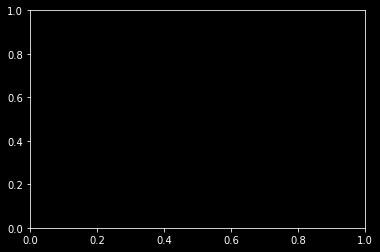

In [128]:
plt.plot(lre, lossi)

In [137]:
emb = C[X]
h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.2942, grad_fn=<NllLossBackward0>)